In [1]:
from matplotlib  import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
from glob        import glob

import numpy   as np
import librosa as lbr
import mido

In [16]:
dataFolder, harmMargin, nBins, nFrames = 'Datasets', 4, 5, 5

def SaveNumPy(waves, name, txtHeader=None, CheckShape=lambda f, n, c: None):
    cqtsData, notesData, warnWaves, excludedWaves = [], [], [], []
    for i, song in enumerate(waves):
        y = lbr.load(song)[0]
        cqts, notes = lbr.magphase(lbr.cqt(lbr.effects.harmonic(y, margin=harmMargin), fmin=lbr.note_to_hz('A0'),
                                           n_bins=88*nBins, bins_per_octave=12*nBins))[0].T, OrderedDict()
        
        folders = song.split('\\')[:-1]
        with open(song[:-3] + 'txt') as trueData:
            if txtHeader: assert trueData.readline() == txtHeader
            for line in trueData:
                if line.isspace(): continue
                onset, _, n = map(float, line.split())
                if folders[1] == 'LabRosa Columbia' and onset > lbr.get_duration(y): break
                assert 0 <= onset < lbr.get_duration(y) and int(n) == n
                notes[lbr.time_to_frames(onset)] = notes.get(lbr.time_to_frames(onset), []) + [int(n) - 21]
        assert (min(min(n) for n in notes.values()) >= 0 and max(max(n) for n in notes.values()) < 88
                and sorted(notes.keys()) == list(notes.keys()))
        
        if cqts[list(notes.keys())].sum(1).min() == 0:
            excludedWaves += [song]
            print('EXCLUDED ', end='')
        else:
            cqts = np.vstack([np.zeros((nFrames // 2, cqts.shape[1]), cqts.dtype), cqts,
                              np.zeros((nFrames // 2, cqts.shape[1]), cqts.dtype)])
            cqtsData += [np.array([cqts[range(frame, frame + nFrames)] for frame in notes.keys()])]
            notesData += [np.zeros((len(notes), 88), np.int8)]
            for j, n in enumerate(notes.values()): notesData[-1][j][n] = 1
            assert len(cqtsData[-1]) == len(notesData[-1])
            if len(cqtsData[-1]) >= nFrames: assert cqtsData[-1][nFrames // 2 : -nFrames // 2].sum(-1).min() > 0
            else: assert cqtsData[-1].sum(-1).min() > 0
            
            if folders[1] == 'MAPS' and folders[3] in ['RAND', 'UCHO'] and len(notesData[-1]) > 1:
                warnWaves += [song]
                print('WARNING ', end='')
                assert len(notesData[-1]) == 2 and np.diff(np.array(list(notes.keys()))) == 1
                cqtsData[-1] = cqtsData[-1][-1].reshape((1,) + cqtsData[-1][-1].shape)
                notesData[-1] = np.sum(notesData[-1], 0, notesData[-1].dtype, keepdims=True)
                assert len(cqtsData[-1]) == len(notesData[-1])
            assert cqtsData[-1].shape[1] == nFrames and notesData[-1].shape[1] == 88 and notesData[-1].dtype == np.int8
            CheckShape(folders, notesData[-1], cqtsData[-1])

        print('{} out of {}: {}'.format(i + 1, len(waves), song))

    if warnWaves:     print('\nWARNING:\n\t',  '\n\t'.join(warnWaves),     sep='')
    if excludedWaves: print('\nEXCLUDED:\n\t', '\n\t'.join(excludedWaves), sep='')

    notesData = np.array(notesData)
    assert (np.array([set(n.ravel()) for n in notesData]) == {0, 1}).all()
    np.save('{}/{}{} Notes Cqt{} Harm{} {}'.format(dataFolder, ('WARN ' if warnWaves or excludedWaves else ''),
                                                   name, nBins, harmMargin, len(notesData)), notesData)
    np.save('{}/{}{} Cqts{} Harm{} {}'. format(dataFolder, ('WARN ' if warnWaves or excludedWaves else ''),
                                               name, nBins, harmMargin, len(cqtsData)),  np.array(cqtsData))
    print('\n{} saved.\n'.format(name))

# Downloaded from Fichiers - Aix-Marseille Université:
https://amubox.univ-amu.fr/index.php/s/iNG0xc5Td1Nv4rR

In [15]:
def CheckMAPS(folders, notes, cqts):
        if folders[3] == 'ISOL': assert (notes.sum(1) == 1).all() and len(notes) == {
            'NO': 1, 'ST': 1, 'RE': 15, 'TR1': 30, 'TR2': 30, 'CH': 176}[folders[4]]
        elif folders[3] == 'RAND': assert (folders[6][0] == 'P' and int(folders[6][1]) in np.arange(2, 8)
                                           and len(notes) == 1 and notes.sum(1) == int(folders[6][1]))
        elif folders[3] == 'UCHO':
            chordFolder, chordParsed = folders[5].split('-'), notes.nonzero()[1]
            assert (chordFolder[0] == 'C0' and len(notes) == 1 and notes.sum(1) == len(chordFolder)
                    and ((chordParsed - chordParsed[0])[1:] == np.array(chordFolder[1:], np.int8)).all())
        else: assert folders[3] == 'MUS' and len(notes) > 1 and (notes.sum(1) > 0).all()

for mapFolder in glob(dataFolder + '\MAPS\*\\'):
    SaveNumPy(glob(mapFolder + '**\*.wav', recursive=True), mapFolder.split('\\')[-2],
              'OnsetTime\tOffsetTime\tMidiPitch\n', CheckMAPS)

1 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n11_ENSTDkAm.wav
2 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n12_ENSTDkAm.wav
3 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n13_ENSTDkAm.wav
4 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n16_ENSTDkAm.wav
5 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n18_ENSTDkAm.wav
6 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n19_ENSTDkAm.wav
7 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n1_ENSTDkAm.wav
8 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n22_ENSTDkAm.wav
9 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n23_ENSTDkAm.wav
10 out of 2970: Data

WARNING 134 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n2_ENSTDkAm.wav
135 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n30_ENSTDkAm.wav
WARNING 136 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n31_ENSTDkAm.wav
WARNING 137 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n32_ENSTDkAm.wav
WARNING 138 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n34_ENSTDkAm.wav
WARNING 139 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n35_ENSTDkAm.wav
WARNING 140 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n37_ENSTDkAm.wav
141 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n38_ENSTDkAm.wav
142 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P4\MA

242 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n3_ENSTDkAm.wav
WARNING 243 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n42_ENSTDkAm.wav
244 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n44_ENSTDkAm.wav
245 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_ENSTDkAm.wav
246 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n47_ENSTDkAm.wav
WARNING 247 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n48_ENSTDkAm.wav
WARNING 248 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n49_ENSTDkAm.wav
249 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n5_ENSTDkAm.wav
250 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96

WARNING 346 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n46_ENSTDkAm.wav
WARNING 347 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n47_ENSTDkAm.wav
348 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n7_ENSTDkAm.wav
349 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n8_ENSTDkAm.wav
350 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n9_ENSTDkAm.wav
351 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n12_ENSTDkAm.wav
352 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n15_ENSTDkAm.wav
353 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n16_ENSTDkAm.wav
354 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P3\MAPS_RAND_P3_M21-108_I60-68_S0_n18_E

465 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n39_ENSTDkAm.wav
466 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n40_ENSTDkAm.wav
467 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n41_ENSTDkAm.wav
468 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n43_ENSTDkAm.wav
469 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n44_ENSTDkAm.wav
470 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n45_ENSTDkAm.wav
471 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n47_ENSTDkAm.wav
472 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n48_ENSTDkAm.wav
473 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P5\MAPS_RAND_P5_M21-108_I60-68_S0_n49_ENSTDkAm.wav
4

577 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n8_ENSTDkAm.wav
578 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n10_ENSTDkAm.wav
WARNING 579 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n11_ENSTDkAm.wav
WARNING 580 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n14_ENSTDkAm.wav
WARNING 581 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n15_ENSTDkAm.wav
582 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n17_ENSTDkAm.wav
WARNING 583 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n19_ENSTDkAm.wav
WARNING 584 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n1_ENSTDkAm.wav
585 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M21-108\I60-68\P7\MAPS_RAND_P

709 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n22_ENSTDkAm.wav
710 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n23_ENSTDkAm.wav
711 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n26_ENSTDkAm.wav
712 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n27_ENSTDkAm.wav
713 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n2_ENSTDkAm.wav
714 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n31_ENSTDkAm.wav
715 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n32_ENSTDkAm.wav
716 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n36_ENSTDkAm.wav
717 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P4\MAPS_RAND_P4_M36-95_I32-96_S0_n37_ENSTDkAm.wav
718 out of 2970: Dat

821 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n35_ENSTDkAm.wav
822 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n36_ENSTDkAm.wav
823 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n37_ENSTDkAm.wav
824 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n41_ENSTDkAm.wav
825 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n43_ENSTDkAm.wav
826 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n45_ENSTDkAm.wav
827 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n46_ENSTDkAm.wav
828 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n49_ENSTDkAm.wav
829 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n50_ENSTDkAm.wav
830 out of 2970: Da

947 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n47_ENSTDkAm.wav
948 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n6_ENSTDkAm.wav
WARNING 949 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n8_ENSTDkAm.wav
WARNING 950 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n9_ENSTDkAm.wav
951 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n11_ENSTDkAm.wav
952 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n13_ENSTDkAm.wav
953 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n17_ENSTDkAm.wav
954 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n19_ENSTDkAm.wav
955 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P3\MAPS_RAND_P3_M36-95_I60-68_S0_n1_ENSTDkAm.wav
956 out

1073 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n49_ENSTDkAm.wav
1074 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n50_ENSTDkAm.wav
1075 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n5_ENSTDkAm.wav
WARNING 1076 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n10_ENSTDkAm.wav
WARNING 1077 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n11_ENSTDkAm.wav
1078 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n12_ENSTDkAm.wav
WARNING 1079 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n14_ENSTDkAm.wav
1080 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n15_ENSTDkAm.wav
1081 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S1_n17_

1182 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n21_ENSTDkAm.wav
1183 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n24_ENSTDkAm.wav
WARNING 1184 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n25_ENSTDkAm.wav
WARNING 1185 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n27_ENSTDkAm.wav
WARNING 1186 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n28_ENSTDkAm.wav
1187 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n2_ENSTDkAm.wav
WARNING 1188 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n30_ENSTDkAm.wav
WARNING 1189 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S1_n32_ENSTDkAm.wav
1190 out of 2970: Datasets\MAPS\ENSTDkAm\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-9

1311 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n2_ENSTDkAm.wav
1312 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n5_ENSTDkAm.wav
1313 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n7_ENSTDkAm.wav
1314 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n8_ENSTDkAm.wav
1315 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-11\MAPS_UCHO_C0-11_I32-96_S1_n9_ENSTDkAm.wav
1316 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n11_ENSTDkAm.wav
1317 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n13_ENSTDkAm.wav
1318 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n14_ENSTDkAm.wav
1319 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n15_ENSTDkAm.wav
1320 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-12\MAPS_UCHO_C0-12_I32-96_S0_n1

1443 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I32-96_S1_n4_ENSTDkAm.wav
1444 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9\MAPS_UCHO_C0-2-6-9_I32-96_S1_n5_ENSTDkAm.wav
1445 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n1_ENSTDkAm.wav
1446 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n2_ENSTDkAm.wav
1447 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n3_ENSTDkAm.wav
1448 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n4_ENSTDkAm.wav
1449 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S0_n7_ENSTDkAm.wav
1450 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n5_ENSTDkAm.wav
WARNING 1451 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-2-6-9-10\MAPS_UCHO_C0-2-6-9-10_I32-96_S1_n6_

1546 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n4_ENSTDkAm.wav
1547 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n5_ENSTDkAm.wav
1548 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n6_ENSTDkAm.wav
1549 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S0_n7_ENSTDkAm.wav
1550 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S1_n1_ENSTDkAm.wav
1551 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-5-9\MAPS_UCHO_C0-3-5-9_I32-96_S1_n3_ENSTDkAm.wav
1552 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n12_ENSTDkAm.wav
1553 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n14_ENSTDkAm.wav
1554 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-6\MAPS_UCHO_C0-3-6_I32-96_S0_n2_ENSTDkAm.wav
1555 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I

1649 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S0_n9_ENSTDkAm.wav
1650 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n13_ENSTDkAm.wav
1651 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7\MAPS_UCHO_C0-3-7_I32-96_S1_n14_ENSTDkAm.wav
1652 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n1_ENSTDkAm.wav
1653 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n2_ENSTDkAm.wav
1654 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n5_ENSTDkAm.wav
1655 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S0_n6_ENSTDkAm.wav
WARNING 1656 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n3_ENSTDkAm.wav
WARNING 1657 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I32-96_S1_n4_ENSTDkAm.wav
1658 out of 2970: D

1770 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S0_n5_ENSTDkAm.wav
1771 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S0_n6_ENSTDkAm.wav
1772 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S0_n7_ENSTDkAm.wav
WARNING 1773 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-8\MAPS_UCHO_C0-4-5-7-8_I32-96_S1_n3_ENSTDkAm.wav
1774 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n2_ENSTDkAm.wav
1775 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n5_ENSTDkAm.wav
1776 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n6_ENSTDkAm.wav
1777 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S0_n7_ENSTDkAm.wav
1778 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-5-7-9\MAPS_UCHO_C0-4-5-7-9_I32-96_S1_n1_ENSTDk

1886 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-8-10\MAPS_UCHO_C0-4-7-8-10_I32-96_S1_n7_ENSTDkAm.wav
1887 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S0_n2_ENSTDkAm.wav
1888 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S0_n7_ENSTDkAm.wav
WARNING 1889 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S1_n1_ENSTDkAm.wav
1890 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S1_n3_ENSTDkAm.wav
1891 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S1_n4_ENSTDkAm.wav
WARNING 1892 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S1_n5_ENSTDkAm.wav
1893 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9\MAPS_UCHO_C0-4-7-9_I32-96_S1_n6_ENSTDkAm.wav
1894 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I32-96_S0_n2_ENSTDkAm.wav
1895 out 

2014 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n1_ENSTDkAm.wav
2015 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n2_ENSTDkAm.wav
2016 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n5_ENSTDkAm.wav
2017 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n6_ENSTDkAm.wav
2018 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S0_n7_ENSTDkAm.wav
2019 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n10_ENSTDkAm.wav
WARNING 2020 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n11_ENSTDkAm.wav
2021 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n12_ENSTDkAm.wav
2022 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n3_ENSTDkAm.wav
2023 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I32-96\C0-6\MAPS_UCHO_C0-6_I32-96_S1_n4_ENSTDkAm.wav

2142 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-4-8-9\MAPS_UCHO_C0-1-4-8-9_I60-68_S1_n7_ENSTDkAm.wav
2143 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n1_ENSTDkAm.wav
2144 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n2_ENSTDkAm.wav
2145 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n4_ENSTDkAm.wav
2146 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n5_ENSTDkAm.wav
2147 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S0_n7_ENSTDkAm.wav
2148 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n3_ENSTDkAm.wav
2149 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8\MAPS_UCHO_C0-1-5-8_I60-68_S1_n6_ENSTDkAm.wav
2150 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-1-5-8-10\MAPS_UCHO_C0-1-5-8-10_I60-68_S0_n1_ENSTDkAm.wav
2151 out of 2970: Datasets\

2263 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S0_n7_ENSTDkAm.wav
2264 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n2_ENSTDkAm.wav
2265 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n4_ENSTDkAm.wav
2266 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-3-6-9\MAPS_UCHO_C0-2-3-6-9_I60-68_S1_n5_ENSTDkAm.wav
2267 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n1_ENSTDkAm.wav
2268 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n3_ENSTDkAm.wav
2269 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n5_ENSTDkAm.wav
2270 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S0_n7_ENSTDkAm.wav
WARNING 2271 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-2-4-5-9\MAPS_UCHO_C0-2-4-5-9_I60-68_S1_n2_ENSTDk

2376 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n6_ENSTDkAm.wav
2377 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S0_n7_ENSTDkAm.wav
2378 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n2_ENSTDkAm.wav
2379 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n3_ENSTDkAm.wav
WARNING 2380 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-8\MAPS_UCHO_C0-3-4-6-8_I60-68_S1_n5_ENSTDkAm.wav
2381 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n2_ENSTDkAm.wav
2382 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S0_n6_ENSTDkAm.wav
WARNING 2383 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60-68_S1_n1_ENSTDkAm.wav
WARNING 2384 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-4-6-9\MAPS_UCHO_C0-3-4-6-9_I60

2497 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S0_n7_ENSTDkAm.wav
WARNING 2498 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n1_ENSTDkAm.wav
2499 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n4_ENSTDkAm.wav
2500 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9\MAPS_UCHO_C0-3-6-9_I60-68_S1_n6_ENSTDkAm.wav
2501 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S0_n3_ENSTDkAm.wav
2502 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S0_n5_ENSTDkAm.wav
2503 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S1_n1_ENSTDkAm.wav
WARNING 2504 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S1_n2_ENSTDkAm.wav
2505 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-6-9-10\MAPS_UCHO_C0-3-6-9-10_I60-68_S1_n4_ENST

2622 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n10_ENSTDkAm.wav
2623 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n12_ENSTDkAm.wav
2624 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n13_ENSTDkAm.wav
2625 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n15_ENSTDkAm.wav
2626 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n2_ENSTDkAm.wav
2627 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n4_ENSTDkAm.wav
2628 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n5_ENSTDkAm.wav
2629 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n6_ENSTDkAm.wav
2630 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO_C0-3-9_I60-68_S0_n7_ENSTDkAm.wav
2631 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-3-9\MAPS_UCHO

2743 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11\MAPS_UCHO_C0-4-7-11_I60-68_S1_n7_ENSTDkAm.wav
WARNING 2744 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n1_ENSTDkAm.wav
2745 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n2_ENSTDkAm.wav
2746 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n3_ENSTDkAm.wav
2747 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n4_ENSTDkAm.wav
WARNING 2748 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n5_ENSTDkAm.wav
WARNING 2749 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n6_ENSTDkAm.wav
WARNING 2750 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-7-11-14\MAPS_UCHO_C0-4-7-11-14_I60-68_S1_n7_ENSTDkAm.wav
2751 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C

2846 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n5_ENSTDkAm.wav
WARNING 2847 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n6_ENSTDkAm.wav
2848 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n7_ENSTDkAm.wav
WARNING 2849 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n8_ENSTDkAm.wav
2850 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-4-9\MAPS_UCHO_C0-4-9_I60-68_S1_n9_ENSTDkAm.wav
2851 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n13_ENSTDkAm.wav
2852 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n2_ENSTDkAm.wav
2853 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n3_ENSTDkAm.wav
2854 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n4_ENSTDkAm.wav
2855 out of 2970: Datasets\MAPS\ENSTDkAm\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5


ENSTDkAm saved.

1 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n11_ENSTDkCl.wav
2 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n12_ENSTDkCl.wav
3 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n16_ENSTDkCl.wav
4 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n17_ENSTDkCl.wav
5 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n19_ENSTDkCl.wav
6 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n1_ENSTDkCl.wav
7 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n21_ENSTDkCl.wav
8 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n22_ENSTDkCl.wav
9 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P2\MAPS_RAND_P2_M21-108_I32-96_S0_n23_ENSTDkCl.wav
10

118 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n43_ENSTDkCl.wav
119 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n44_ENSTDkCl.wav
120 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n45_ENSTDkCl.wav
121 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n46_ENSTDkCl.wav
122 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n48_ENSTDkCl.wav
123 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n50_ENSTDkCl.wav
124 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n5_ENSTDkCl.wav
125 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S0_n8_ENSTDkCl.wav
126 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P4\MAPS_RAND_P4_M21-108_I32-96_S1_n14_ENSTDkCl.wav
WAR

238 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n36_ENSTDkCl.wav
239 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n38_ENSTDkCl.wav
240 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n39_ENSTDkCl.wav
WARNING 241 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n40_ENSTDkCl.wav
WARNING 242 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n41_ENSTDkCl.wav
243 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n42_ENSTDkCl.wav
244 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n45_ENSTDkCl.wav
245 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-96_S1_n46_ENSTDkCl.wav
WARNING 246 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I32-96\P6\MAPS_RAND_P6_M21-108_I32-

334 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n18_ENSTDkCl.wav
WARNING 335 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n19_ENSTDkCl.wav
WARNING 336 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n22_ENSTDkCl.wav
WARNING 337 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n23_ENSTDkCl.wav
338 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n24_ENSTDkCl.wav
339 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n27_ENSTDkCl.wav
WARNING 340 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n28_ENSTDkCl.wav
341 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-108_I60-68_S1_n32_ENSTDkCl.wav
342 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P2\MAPS_RAND_P2_M21-

418 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n46_ENSTDkCl.wav
419 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n48_ENSTDkCl.wav
420 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n4_ENSTDkCl.wav
421 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n50_ENSTDkCl.wav
422 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n6_ENSTDkCl.wav
423 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S0_n7_ENSTDkCl.wav
424 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n10_ENSTDkCl.wav
WARNING 425 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n11_ENSTDkCl.wav
WARNING 426 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P4\MAPS_RAND_P4_M21-108_I60-68_S1_n12_E

570 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n44_ENSTDkCl.wav
571 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n45_ENSTDkCl.wav
572 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n46_ENSTDkCl.wav
573 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n49_ENSTDkCl.wav
574 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n50_ENSTDkCl.wav
575 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n7_ENSTDkCl.wav
576 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S0_n9_ENSTDkCl.wav
577 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n12_ENSTDkCl.wav
WARNING 578 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M21-108\I60-68\P7\MAPS_RAND_P7_M21-108_I60-68_S1_n14_ENSTDkCl

689 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n39_ENSTDkCl.wav
690 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n3_ENSTDkCl.wav
691 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n41_ENSTDkCl.wav
692 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n42_ENSTDkCl.wav
WARNING 693 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n45_ENSTDkCl.wav
694 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n46_ENSTDkCl.wav
695 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n48_ENSTDkCl.wav
WARNING 696 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n49_ENSTDkCl.wav
WARNING 697 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P3\MAPS_RAND_P3_M36-95_I32-96_S1_n4_ENSTDkCl.w

803 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n13_ENSTDkCl.wav
804 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n14_ENSTDkCl.wav
805 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n15_ENSTDkCl.wav
806 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n16_ENSTDkCl.wav
807 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n19_ENSTDkCl.wav
808 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n20_ENSTDkCl.wav
809 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n21_ENSTDkCl.wav
810 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n24_ENSTDkCl.wav
811 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I32-96\P6\MAPS_RAND_P6_M36-95_I32-96_S0_n25_ENSTDkCl.wav
812 out of 2970: Da

925 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n47_ENSTDkCl.wav
926 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n49_ENSTDkCl.wav
927 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S0_n5_ENSTDkCl.wav
928 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n12_ENSTDkCl.wav
WARNING 929 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n13_ENSTDkCl.wav
WARNING 930 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n15_ENSTDkCl.wav
931 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n18_ENSTDkCl.wav
932 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n19_ENSTDkCl.wav
933 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P2\MAPS_RAND_P2_M36-95_I60-68_S1_n21_ENSTDkCl.wav
934 

1044 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n45_ENSTDkCl.wav
WARNING 1045 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n46_ENSTDkCl.wav
WARNING 1046 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n48_ENSTDkCl.wav
1047 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n5_ENSTDkCl.wav
1048 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n6_ENSTDkCl.wav
WARNING 1049 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n8_ENSTDkCl.wav
WARNING 1050 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P4\MAPS_RAND_P4_M36-95_I60-68_S1_n9_ENSTDkCl.wav
1051 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0_n11_ENSTDkCl.wav
1052 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P5\MAPS_RAND_P5_M36-95_I60-68_S0

1156 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n22_ENSTDkCl.wav
1157 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n23_ENSTDkCl.wav
1158 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n24_ENSTDkCl.wav
1159 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n26_ENSTDkCl.wav
1160 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n27_ENSTDkCl.wav
1161 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n29_ENSTDkCl.wav
1162 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n2_ENSTDkCl.wav
1163 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n30_ENSTDkCl.wav
1164 out of 2970: Datasets\MAPS\ENSTDkCl\RAND\M36-95\I60-68\P7\MAPS_RAND_P7_M36-95_I60-68_S0_n31_ENSTDkCl.wav
1165 out of

1273 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n5_ENSTDkCl.wav
1274 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S0_n6_ENSTDkCl.wav
WARNING 1275 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n2_ENSTDkCl.wav
WARNING 1276 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n3_ENSTDkCl.wav
1277 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n4_ENSTDkCl.wav
WARNING 1278 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9\MAPS_UCHO_C0-1-5-9_I32-96_S1_n7_ENSTDkCl.wav
1279 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I32-96_S0_n2_ENSTDkCl.wav
1280 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I32-96_S0_n4_ENSTDkCl.wav
1281 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-1-5-9-10\MAPS_UCHO_C0-1-5-9-10_I32-96_S0_n6_ENSTDkCl

1404 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n1_ENSTDkCl.wav
1405 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n2_ENSTDkCl.wav
1406 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n3_ENSTDkCl.wav
1407 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n5_ENSTDkCl.wav
WARNING 1408 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n6_ENSTDkCl.wav
WARNING 1409 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-10\MAPS_UCHO_C0-2-5-8-10_I32-96_S1_n7_ENSTDkCl.wav
1410 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n1_ENSTDkCl.wav
1411 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-5-8-11_I32-96_S0_n2_ENSTDkCl.wav
1412 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-2-5-8-11\MAPS_UCHO_C0-2-

WARNING 1523 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-6-9\MAPS_UCHO_C0-3-5-6-9_I32-96_S1_n7_ENSTDkCl.wav
1524 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n1_ENSTDkCl.wav
1525 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S0_n3_ENSTDkCl.wav
WARNING 1526 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n2_ENSTDkCl.wav
WARNING 1527 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n4_ENSTDkCl.wav
WARNING 1528 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n5_ENSTDkCl.wav
1529 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n6_ENSTDkCl.wav
1530 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-8\MAPS_UCHO_C0-3-5-7-8_I32-96_S1_n7_ENSTDkCl.wav
1531 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-5-7-9\MAPS_UCHO_C0-3-5

WARNING 1661 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I32-96_S1_n1_ENSTDkCl.wav
1662 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I32-96_S1_n2_ENSTDkCl.wav
1663 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I32-96_S1_n3_ENSTDkCl.wav
WARNING 1664 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I32-96_S1_n6_ENSTDkCl.wav
WARNING 1665 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-13\MAPS_UCHO_C0-3-7-10-13_I32-96_S1_n7_ENSTDkCl.wav
1666 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I32-96_S0_n1_ENSTDkCl.wav
1667 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I32-96_S0_n5_ENSTDkCl.wav
1668 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-3-7-10-14\MAPS_UCHO_C0-3-7-10-14_I32-96_S0_n6_ENSTDkCl.wav
WARNING 1669 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I3

1796 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S0_n2_ENSTDkCl.wav
1797 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S0_n5_ENSTDkCl.wav
1798 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S0_n7_ENSTDkCl.wav
1799 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n3_ENSTDkCl.wav
1800 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n4_ENSTDkCl.wav
WARNING 1801 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-5-9\MAPS_UCHO_C0-4-5-9_I32-96_S1_n6_ENSTDkCl.wav
1802 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n3_ENSTDkCl.wav
1803 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n4_ENSTDkCl.wav
1804 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-6-7-9\MAPS_UCHO_C0-4-6-7-9_I32-96_S0_n5_ENSTDkCl.wav
1805 out of 2970:

WARNING 1899 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I32-96_S1_n1_ENSTDkCl.wav
1900 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-10\MAPS_UCHO_C0-4-7-9-10_I32-96_S1_n6_ENSTDkCl.wav
1901 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n2_ENSTDkCl.wav
1902 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n5_ENSTDkCl.wav
1903 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S0_n6_ENSTDkCl.wav
1904 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n1_ENSTDkCl.wav
WARNING 1905 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n3_ENSTDkCl.wav
WARNING 1906 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UCHO_C0-4-7-9-11_I32-96_S1_n4_ENSTDkCl.wav
1907 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-4-7-9-11\MAPS_UC

1981 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n12_ENSTDkCl.wav
1982 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n1_ENSTDkCl.wav
1983 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n6_ENSTDkCl.wav
1984 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n7_ENSTDkCl.wav
1985 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S0_n9_ENSTDkCl.wav
1986 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n10_ENSTDkCl.wav
WARNING 1987 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n11_ENSTDkCl.wav
1988 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n13_ENSTDkCl.wav
1989 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\MAPS_UCHO_C0-5-8_I32-96_S1_n14_ENSTDkCl.wav
1990 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I32-96\C0-5-8\

2106 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S1_n4_ENSTDkCl.wav
WARNING 2107 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-4-8\MAPS_UCHO_C0-1-3-4-8_I60-68_S1_n6_ENSTDkCl.wav
2108 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n1_ENSTDkCl.wav
2109 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n2_ENSTDkCl.wav
2110 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S0_n3_ENSTDkCl.wav
WARNING 2111 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n4_ENSTDkCl.wav
2112 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n5_ENSTDkCl.wav
WARNING 2113 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60-68_S1_n6_ENSTDkCl.wav
2114 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-1-3-5-8\MAPS_UCHO_C0-1-3-5-8_I60

2247 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S0_n5_ENSTDkCl.wav
WARNING 2248 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n2_ENSTDkCl.wav
WARNING 2249 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n3_ENSTDkCl.wav
WARNING 2250 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n4_ENSTDkCl.wav
2251 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n6_ENSTDkCl.wav
WARNING 2252 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-8\MAPS_UCHO_C0-2-3-5-8_I60-68_S1_n7_ENSTDkCl.wav
2253 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S0_n4_ENSTDkCl.wav
WARNING 2254 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-9\MAPS_UCHO_C0-2-3-5-9_I60-68_S1_n1_ENSTDkCl.wav
2255 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-2-3-5-9\MAPS_UCH

WARNING 2392 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S1_n2_ENSTDkCl.wav
2393 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S1_n5_ENSTDkCl.wav
2394 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-4-8\MAPS_UCHO_C0-3-4-8_I60-68_S1_n7_ENSTDkCl.wav
2395 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S0_n1_ENSTDkCl.wav
2396 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S0_n3_ENSTDkCl.wav
2397 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S0_n4_ENSTDkCl.wav
2398 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S0_n7_ENSTDkCl.wav
WARNING 2399 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n2_ENSTDkCl.wav
WARNING 2400 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-5-6-8\MAPS_UCHO_C0-3-5-6-8_I60-68_S1_n5_EN

2530 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n11_ENSTDkCl.wav
2531 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n12_ENSTDkCl.wav
WARNING 2532 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n13_ENSTDkCl.wav
2533 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n15_ENSTDkCl.wav
WARNING 2534 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n3_ENSTDkCl.wav
2535 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n5_ENSTDkCl.wav
2536 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7\MAPS_UCHO_C0-3-7_I60-68_S1_n9_ENSTDkCl.wav
2537 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S0_n2_ENSTDkCl.wav
2538 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-3-7-10\MAPS_UCHO_C0-3-7-10_I60-68_S0_n5_ENSTDkCl.wav
2539 out of 2970: Datasets\MAPS\ENSTDkCl\

2638 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n13_ENSTDkCl.wav
2639 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n14_ENSTDkCl.wav
2640 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n1_ENSTDkCl.wav
2641 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n2_ENSTDkCl.wav
2642 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n3_ENSTDkCl.wav
2643 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n5_ENSTDkCl.wav
2644 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S0_n8_ENSTDkCl.wav
WARNING 2645 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n11_ENSTDkCl.wav
WARNING 2646 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n12_ENSTDkCl.wav
2647 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4\MAPS_UCHO_C0-4_I60-68_S1_n15_EN

2715 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7\MAPS_UCHO_C0-4-7_I60-68_S1_n9_ENSTDkCl.wav
2716 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n3_ENSTDkCl.wav
2717 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n5_ENSTDkCl.wav
2718 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S0_n7_ENSTDkCl.wav
2719 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S1_n1_ENSTDkCl.wav
WARNING 2720 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S1_n2_ENSTDkCl.wav
2721 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S1_n4_ENSTDkCl.wav
WARNING 2722 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10\MAPS_UCHO_C0-4-7-10_I60-68_S1_n6_ENSTDkCl.wav
2723 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-4-7-10-13\MAPS_UCHO_C0-4-7-10-13_I60-68_S0_n1_ENSTDkCl.wav
272

2853 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n14_ENSTDkCl.wav
2854 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n15_ENSTDkCl.wav
2855 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n2_ENSTDkCl.wav
2856 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n4_ENSTDkCl.wav
2857 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n5_ENSTDkCl.wav
2858 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S0_n8_ENSTDkCl.wav
2859 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n10_ENSTDkCl.wav
WARNING 2860 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n11_ENSTDkCl.wav
2861 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n1_ENSTDkCl.wav
WARNING 2862 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-5\MAPS_UCHO_C0-5_I60-68_S1_n3_ENS

2945 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n15_ENSTDkCl.wav
2946 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n1_ENSTDkCl.wav
2947 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n3_ENSTDkCl.wav
2948 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n5_ENSTDkCl.wav
2949 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n6_ENSTDkCl.wav
2950 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n7_ENSTDkCl.wav
2951 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S0_n9_ENSTDkCl.wav
2952 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S1_n11_ENSTDkCl.wav
WARNING 2953 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S1_n2_ENSTDkCl.wav
2954 out of 2970: Datasets\MAPS\ENSTDkCl\UCHO\I60-68\C0-8\MAPS_UCHO_C0-8_I60-68_S1_n4_ENSTDkCl.wav



ENSTDkCl saved.



In [18]:
def CombineNumPys(cqtFiles, noteFiles, name):
    cqts, notes = [], []
    for c, n in zip(cqtFiles, noteFiles):
        prefix, nSamples = c.split()[0], c.split()[-1].split('.')[0]
        assert prefix == n.split()[0] and nSamples == n.split()[-1].split('.')[0]
        cqts, notes = np.hstack([cqts, np.load(c)]), np.hstack([notes, np.load(n)])
        print(prefix, nSamples, 'loaded.')
    
    assert (len(cqts) == len(notes) and np.array([len(c) == len(n) for c, n in zip(cqts, notes)]).all()
        and np.array([n.shape[1] == 88 for n in notes]).all()
        and np.array([c.shape[1] == nFrames for c in cqts[1:]]).all()
        and np.array([c.shape[2] % 88 == 0 for c in cqts[1:]]).all()
        and np.array([c.shape[2] == cqts[0].shape[2] for c in cqts[1:]]).all()
        and (np.array([set(n.ravel()) for n in notes]) == {0, 1}).all())
    
    print(len(notes), 'samples,', end='\t')
    cqts, notes = map(np.vstack, [cqts, notes])
    print(len(notes), 'chords')
    print('cqts before norm in range [{:.3f} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))
    print('Not using normalization')
    '''
    cqts /= cqts.max(2).max(1).reshape(len(cqts), 1, 1)
    print('cqts after norm in range  [{:.3f} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))
    
    # Ideally there should only be one cqt=1 per chord after normalization, but there may be slightly more
    numOnes = len(np.hstack([(c == 1).nonzero()[0] for c in cqts])), len(np.hstack([(c == 1).nonzero()[1] for c in cqts]))
    assert (len(cqts) / numOnes[0] > .9978 and len(cqts) / numOnes[0] <= 1 and
            len(cqts) / numOnes[1] > .9978 and len(cqts) / numOnes[0] <= 1)
    '''
    np.save('{}/{} Cqts{} Float16 {}'.format(dataFolder, name, nBins, len(cqts)), cqts.astype(np.float16))
    np.save('{}/{} Notes {}'.format(dataFolder, name, len(notes)), notes)
    print("Combined NumPy's saved.")

CombineNumPys(glob(dataFolder + '/MAPS/*Cqts*.npy'), glob(dataFolder + '/MAPS/*Notes*.npy'), 'MAPS')

Datasets/MAPS\AkPnBcht 3735 loaded.
Datasets/MAPS\AkPnBsdf 3735 loaded.
Datasets/MAPS\AkPnCGdD 3735 loaded.
Datasets/MAPS\AkPnStgb 3735 loaded.
Datasets/MAPS\ENSTDkAm 3735 loaded.
Datasets/MAPS\ENSTDkCl 3735 loaded.
Datasets/MAPS\SptkBGAm 3735 loaded.
Datasets/MAPS\SptkBGCl 30 loaded.
Datasets/MAPS\StbgTGd2 3735 loaded.
29910 samples,	408870 chords
cqts before norm in range [0.000 - 0.010 - 17.661]
Not using normalization
Combined NumPy's saved.


In [ ]:
def MidiParse(midiName):
    totalTime = 0
    with open(midiName[:-3] + 'txt', 'w') as txtFile:
        txtFile.write('OnsetTime\tOffsetTime=?\tMidiPitch')
        for msg in mido.MidiFile(midiName):
            totalTime += msg.time
            if msg.type == 'note_on': txtFile.write('\n{} {} {}'.format(totalTime, 0, msg.note))

# Downloaded from International Audio Laboratories Erlangen:
https://www.audiolabs-erlangen.de/resources/MIR/SMD/    /midi

In [19]:
erlangenFolder = 'AudioLabs-Erlangen'
#for midiName in glob('{}\{}\*.mid'.format(dataFolder, erlangenFolder)): MidiParse(midiName)

def SimpleCheck(folders, notes, cqts): assert len(notes) > 1 and (notes.sum(1) > 0).all()
SaveNumPy(glob('{}\{}\*.mp3'.format(dataFolder, erlangenFolder))[:25], erlangenFolder + '1',
          'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)
SaveNumPy(glob('{}\{}\*.mp3'.format(dataFolder, erlangenFolder))[25:], erlangenFolder + '2',
          'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV849-01_001_20090916-SMD.mp3
2 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV849-02_001_20090916-SMD.mp3
3 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV871-01_002_20090916-SMD.mp3
4 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV871-02_002_20090916-SMD.mp3
5 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV875-01_002_20090916-SMD.mp3
6 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV875-02_002_20090916-SMD.mp3
7 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV888-01_008_20110315-SMD.mp3
8 out of 25: Datasets\AudioLabs-Erlangen\Bach_BWV888-02_008_20110315-SMD.mp3
9 out of 25: Datasets\AudioLabs-Erlangen\Bartok_SZ080-01_002_20110315-SMD.mp3
10 out of 25: Datasets\AudioLabs-Erlangen\Bartok_SZ080-02_002_20110315-SMD.mp3
11 out of 25: Datasets\AudioLabs-Erlangen\Bartok_SZ080-03_002_20110315-SMD.mp3
12 out of 25: Datasets\AudioLabs-Erlangen\Beethoven_Op027No1-01_003_20090916-SMD.mp3
13 out of 25: Datasets\AudioLabs-Erlangen\Beethoven_Op027No1-02

In [23]:
CombineNumPys(glob('{}/{}/{}*Cqts*.npy'.format(dataFolder, erlangenFolder, erlangenFolder)),
              glob('{}/{}/{}*Notes*.npy'.format(dataFolder, erlangenFolder, erlangenFolder)), erlangenFolder)

Datasets/AudioLabs-Erlangen\AudioLabs-Erlangen1 25 loaded.
Datasets/AudioLabs-Erlangen\AudioLabs-Erlangen2 25 loaded.
50 samples,	103928 chords
cqts before norm in range [0.000 - 0.021 - 11.730]
Not using normalization
Combined NumPy's saved.


# Downloaded from Laboratory for the Recognition and Organization<br>of Speech and Audio (LabROSA) Columbia:
https://labrosa.ee.columbia.edu/projects/piano/

In [57]:
labRosaFolder = 'LabRosa Columbia'
for midiName in glob('{}\{}\*.mid'.format(dataFolder, labRosaFolder)): MidiParse(midiName)
SaveNumPy(glob('{}\{}\*.wav'.format(dataFolder, labRosaFolder)), labRosaFolder, 'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 29: Datasets\LabRosa Columbia\alb_esp1MINp_align.wav
2 out of 29: Datasets\LabRosa Columbia\bach_847MINp_align.wav
3 out of 29: Datasets\LabRosa Columbia\bach_850MINp_align.wav
4 out of 29: Datasets\LabRosa Columbia\bal_islameiMINp_align.wav
5 out of 29: Datasets\LabRosa Columbia\beet_eliseMINp_align.wav
6 out of 29: Datasets\LabRosa Columbia\beet_pathetique_1MINp_align.wav
7 out of 29: Datasets\LabRosa Columbia\beet_pathetique_3MINp_align.wav
8 out of 29: Datasets\LabRosa Columbia\bor_ps1MINp_align.wav
9 out of 29: Datasets\LabRosa Columbia\br_im2MINp_align.wav
10 out of 29: Datasets\LabRosa Columbia\br_im6MINp_align.wav
11 out of 29: Datasets\LabRosa Columbia\burg_perlenMINp_align.wav
12 out of 29: Datasets\LabRosa Columbia\chpn_op10_e01MINp_align.wav
13 out of 29: Datasets\LabRosa Columbia\chpn_op7_1MINp_align.wav
14 out of 29: Datasets\LabRosa Columbia\deb_passMINp_align.wav
15 out of 29: Datasets\LabRosa Columbia\gra_esp_2MINp_align.wav
16 out of 29: Datasets\LabRosa Colu

# Downloaded from<br>Music and Audio Computing Lab, Vienna 4x22 corpus (Aligned):
http://mac.kaist.ac.kr/~ilcobo2/alignWithAMT/

In [42]:
viennaFolder = 'Vienna 4x22 corpus (Aligned)'
for midiName in glob('{}\{}\*.mid'.format(dataFolder, viennaFolder)): MidiParse(midiName)
SaveNumPy(glob('{}\{}\*.mp3'.format(dataFolder, viennaFolder)), 'Vienna', 'OnsetTime\tOffsetTime=?\tMidiPitch\n', SimpleCheck)

1 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p02_aligned.mp3
2 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p03_aligned.mp3
3 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p04_aligned.mp3
4 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op10_no3_p05_aligned.mp3
5 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p02_aligned.mp3
6 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p03_aligned.mp3
7 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p04_aligned.mp3
8 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Chopin_op38_p05_aligned.mp3
9 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p02_aligned.mp3
10 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p03_aligned.mp3
11 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p04_aligned.mp3
12 out of 16: Datasets\Vienna 4x22 corpus (Aligned)\Mozart_K331_1st-mov_p05_aligned.mp3
1

## LabRosa and Vienna datasets are much smaller compared to AudioLabs-Erlangen and especially MAPS. Use only MAPS and AudioLabs-Erlangen for training:

In [24]:
cqts, notes = map(lambda name: np.vstack([np.load('{}/{} {} {}.npy'.format(dataFolder, pref, name, suff)) for pref, suff in zip(
    ['MAPS', erlangenFolder], [408_870, 103_928])]), ['Cqts5 Float16', 'Notes'])

np.save('{}/Cqts Float16 {}'.format(dataFolder, len(cqts)), cqts)
np.save('{}/Notes {}'.format(dataFolder, len(notes)), notes)
"Combined NumPy's saved."

"Combined NumPy's saved."

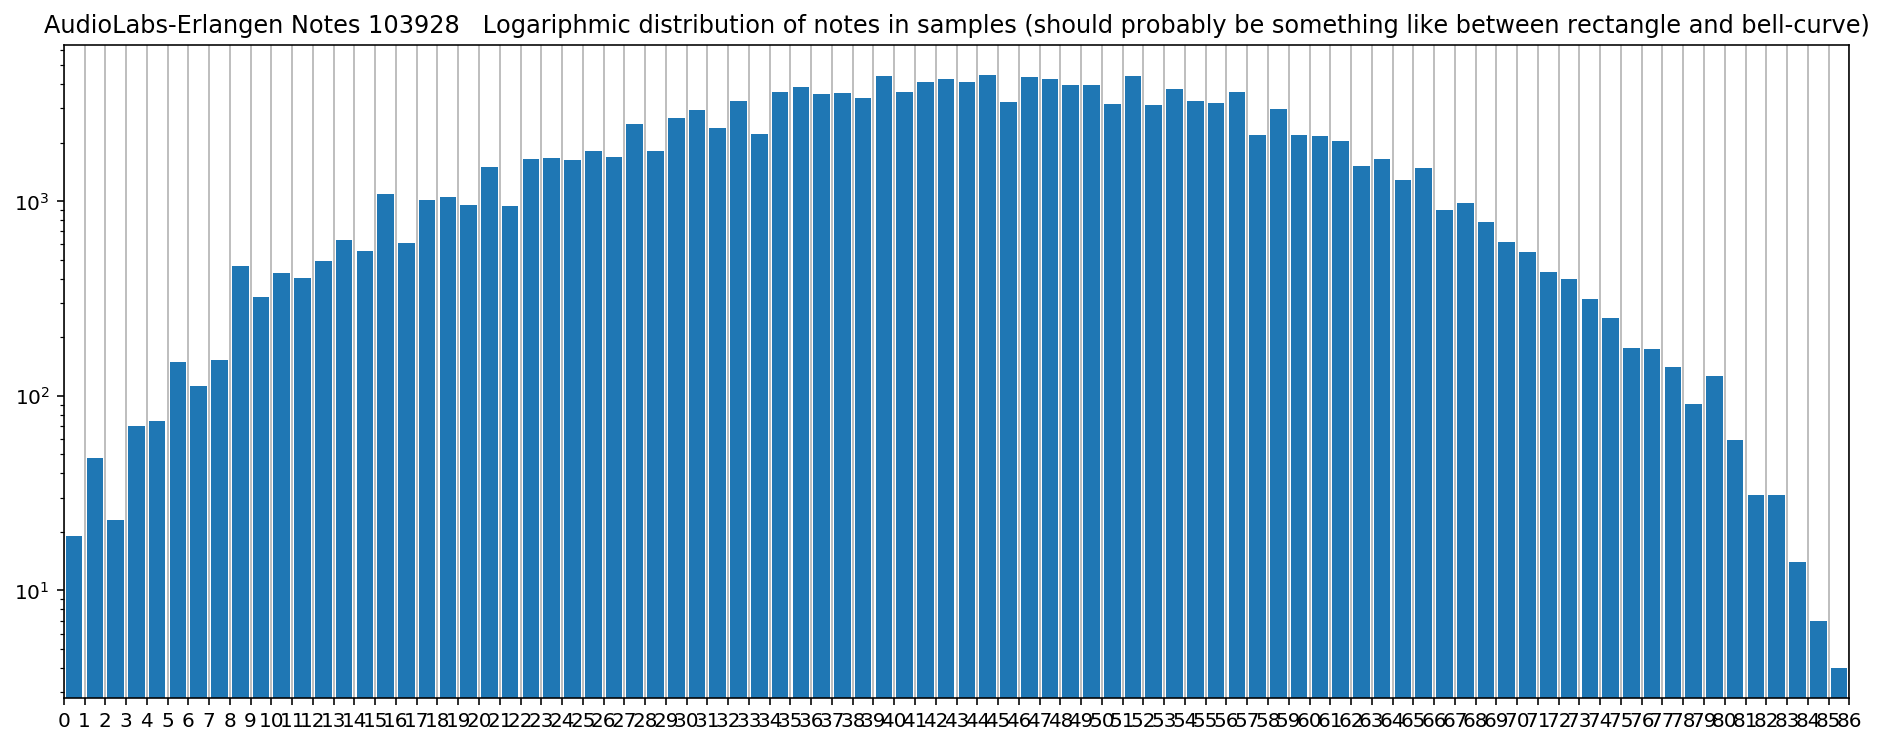

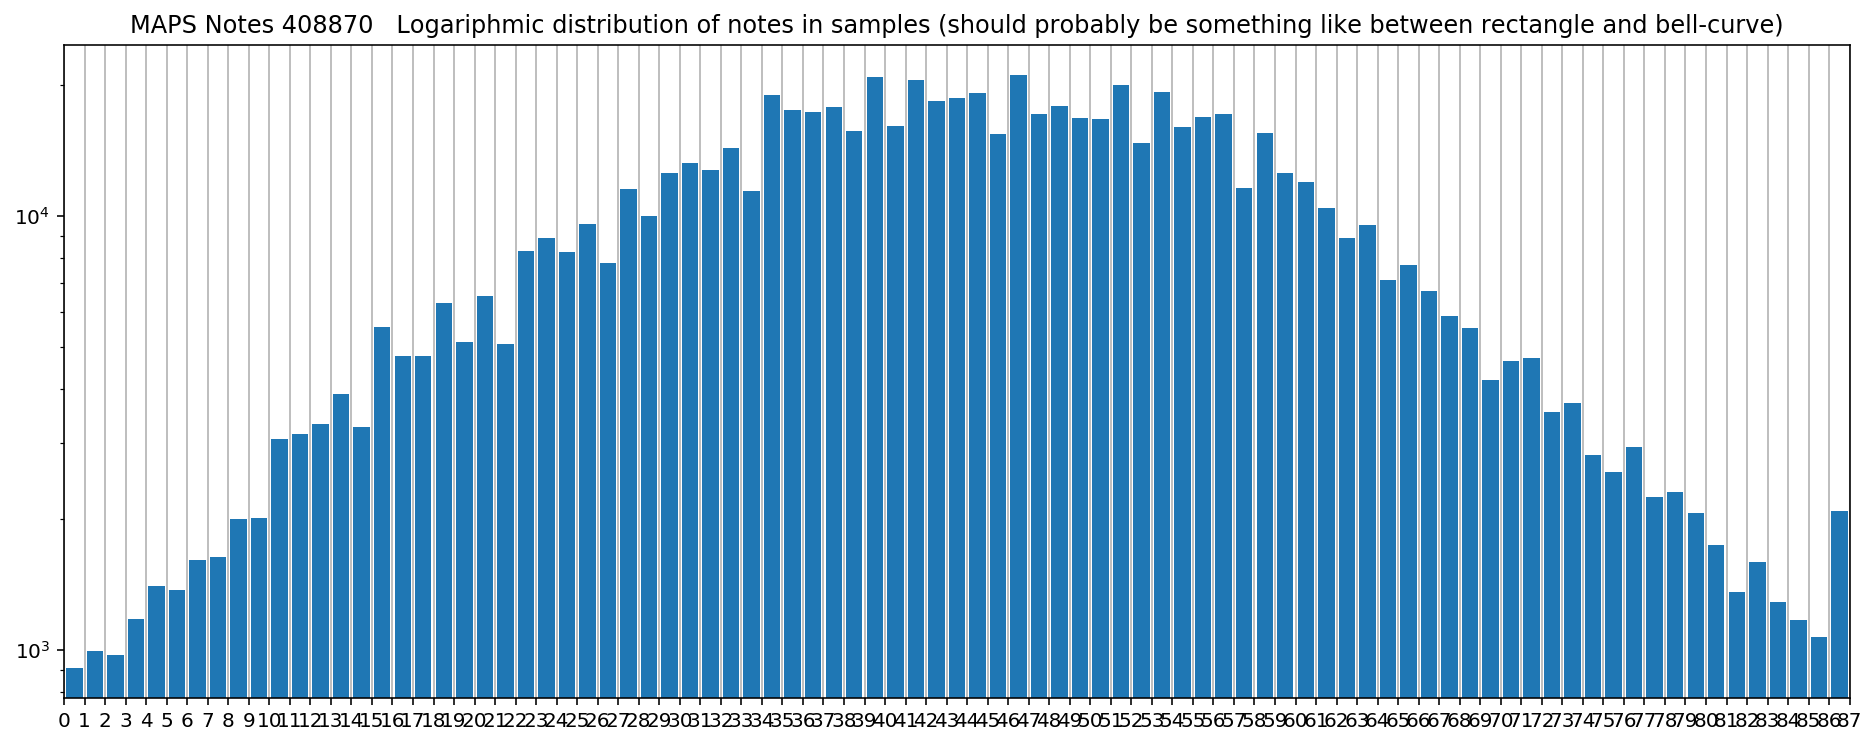

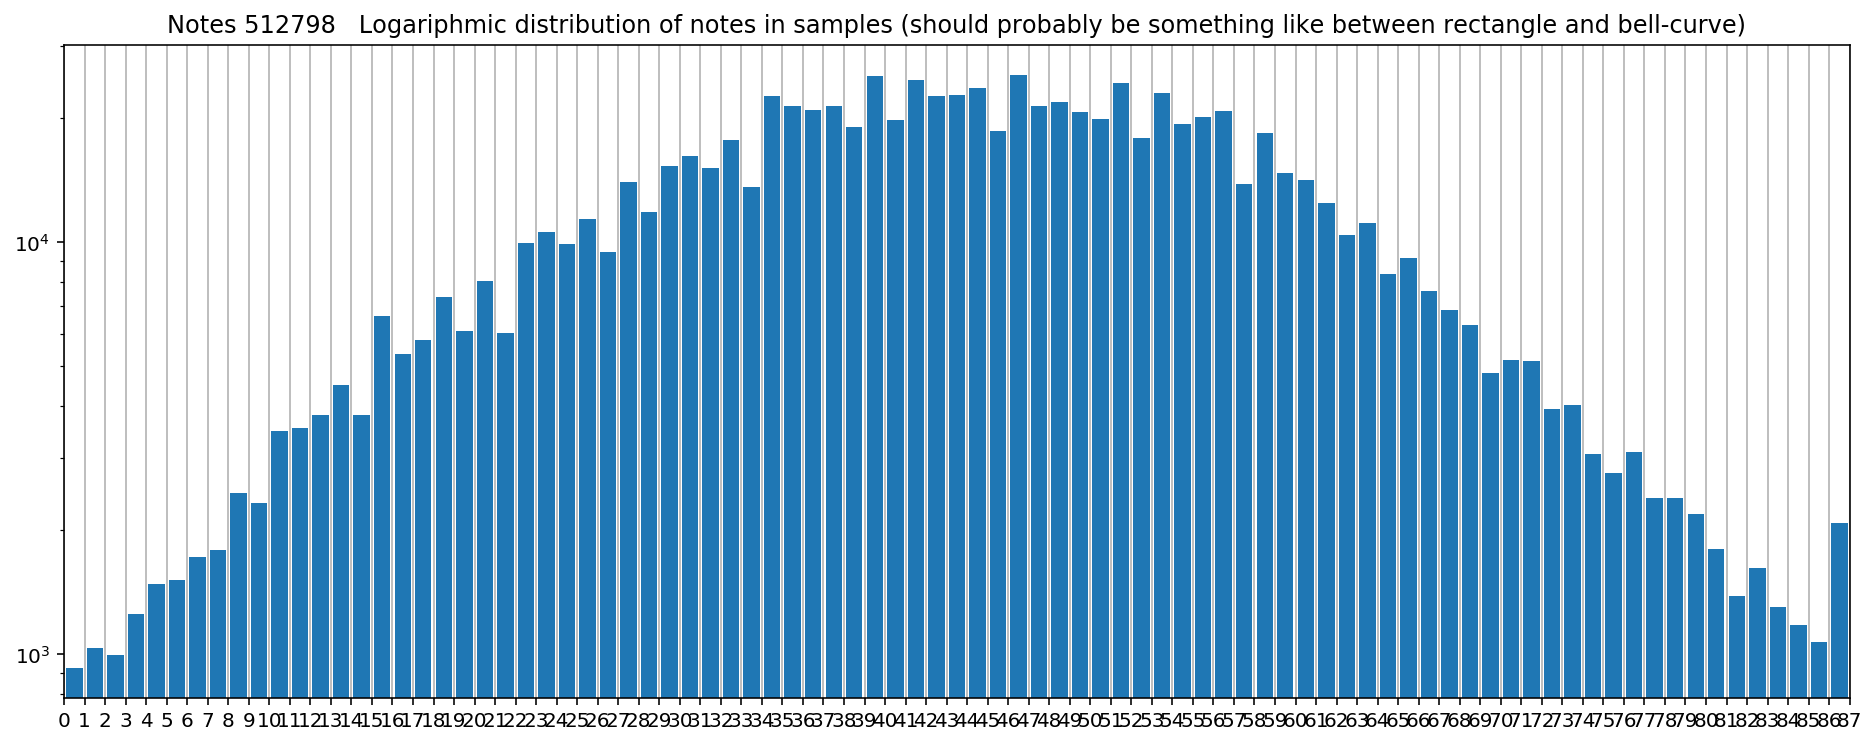

In [25]:
def PlotNotesCount(notesFile):
    plt.figure(figsize=(16, 6))
    
    notes = np.load('{}/{}.npy'.format(dataFolder, notesFile))
    if len(notes.shape) in [1, 3]: notes = np.vstack(notes)
    noteCounts = notes.nonzero()[1]
    minNote, maxNote = noteCounts.min(), noteCounts.max()
    
    plt.hist(noteCounts, maxNote - minNote, rwidth=.8, log=True)
    plt.title(notesFile + '   Logariphmic distribution of notes in samples '
              '(should probably be something like between rectangle and bell-curve)')
    plt.xlim(minNote, maxNote)
    plt.xticks(range(minNote, maxNote + 1))
    plt.grid(axis='x')

for notesNumPy in ['AudioLabs-Erlangen Notes 103928', 'MAPS Notes 408870', 'Notes 512798']: PlotNotesCount(notesNumPy)